In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import abupy

abupy.env.disable_example_env_ipython()

disable example env


In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop  # 止盈止损策略、单日最大跌幅止损策略
from abupy import AbuFactorBuyBreak, AbuFactorSellBreak # 正向突破买入策略、正向突破卖出策略
from abupy import ABuGridHelper # 组合参数辅助模块


"""买入因子组合"""

buy_bk_factor_grid1 = {
    'class': [AbuFactorBuyBreak], # 60天突破买入因子
    'xd': [60]
}

buy_bk_factor_grid2 = {
    'class': [AbuFactorBuyBreak], # 90天突破买入因子
    'xd': [90]
}

buy_factors_product = ABuGridHelper.gen_factor_grid( 
    ABuGridHelper.K_GEN_FACTOR_PARAMS_BUY, [buy_bk_factor_grid1, buy_bk_factor_grid2])


"""卖出因子组合"""

sell_bk_factor_grid = {
    'class': [AbuFactorSellBreak], # 60天突破卖出因子
    'xd': [60]}

# AbuFactorAtrNStop止盈止损策略，止盈止损参数范围

stop_win_range = np.arange(2.0, 3.0, 1) # 2  2.5  3
stop_loss_range = np.arange(1.5, 2.0, 1) # 1.5  2


sell_atr_nstop_factor_grid = {
              'class': [AbuFactorAtrNStop], 
              'stop_win_n'   : stop_win_range,
              'stop_loss_n'   : stop_loss_range
         }

# AbuFactorPreAtrNStop单日最大跌幅止损策略，止损参数范围
    
pre_atr_range = np.arange(1.0, 2.0, 1) # 1  1,5  2

sell_pre_atr_nstop_factor_grid = {
              'class': [AbuFactorPreAtrNStop],
              'pre_atr_n'   : pre_atr_range,
         }


sell_factors_product = ABuGridHelper.gen_factor_grid(
    ABuGridHelper.K_GEN_FACTOR_PARAMS_SELL,
    [sell_bk_factor_grid,sell_atr_nstop_factor_grid,sell_pre_atr_nstop_factor_grid], need_empty_sell=True)



print('组合因子参数数量{}'.format(len(buy_factors_product) * len(sell_factors_product) ))

组合因子参数数量15


In [3]:
from abupy import GridSearch # 最优grid search对外接口类
from abupy import EMarketTargetType# 市场类型  # ABuProgress 辅助进度显示模块

# A股涨跌停的特殊处理
from abupy import slippage
# 开启针对非集合竞价阶段的涨停，滑点买入价格以高概率在接近涨停的价格买入
slippage.sbb.g_enable_limit_up = True
# 将集合竞价阶段的涨停买入成功概率设置为0，如果设置为0.2即20%概率成功买入
slippage.sbb.g_pre_limit_up_rate = 0
# 开启针对非集合竞价阶段的跌停，滑点卖出价格以高概率在接近跌停的价格卖出
slippage.ssb.g_enable_limit_down = True
# 将集合竞价阶段的跌停卖出成功概率设置为0, 如果设置为0.2即20%概率成功卖出
slippage.ssb.g_pre_limit_down_rate = 0

abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN # 设置为A股回测环境

# 初始资金数
read_cash = 1000000

choice_symbols = ['000400', '000525' '600104']
grid_search = GridSearch(read_cash, choice_symbols,
                         buy_factors_product=buy_factors_product,
                         sell_factors_product=sell_factors_product)

In [4]:
from abupy import ABuFileUtil # 文件处理读取写入
import ipywidgets # 控件交互 

scores = None
score_tuple_array = None

def run_grid_search():
    global scores, score_tuple_array
    # 运行GridSearch n_jobs=-1启动cpu个数的进程数
    scores, score_tuple_array = grid_search.fit(n_jobs=-1)
    # 运行完成输出的score_tuple_array可以使用dump_pickle保存在本地，以方便之后使用
    ABuFileUtil.dump_pickle(score_tuple_array, '../gen/score_tuple_array')

def load_score_cache():
    """有本地数据score_tuple_array后，即可以从本地缓存读取score_tuple_array"""
    global scores, score_tuple_array
    
    with AbuBlockProgress('load score cache'):
        score_tuple_array = ABuFileUtil.load_pickle('../gen/score_tuple_array')
        if not hasattr(grid_search, 'best_score_tuple_grid'):
            # load_pickle的grid_search没有赋予best_score_tuple_grid，这里补上
            from abupy import make_scorer, WrsmScorer
            scores = make_scorer(score_tuple_array, WrsmScorer)
            grid_search.best_score_tuple_grid = score_tuple_array[scores.index[-1]]
        print('load complete!')
        
def select(select):
    if select == 'run gird search':
        run_grid_search()
    else: # load score cache
        load_score_cache()

_ = ipywidgets.interact_manual(select, select=['run gird search', 'load score cache'])

interactive(children=(Dropdown(description='select', options=('run gird search', 'load score cache'), value='r…

In [5]:
print('最终评分结果数量{}'.format(len(scores)))
scores # 默认评分

最终评分结果数量15


4     0.0357
9     0.0536
14    0.1250
6     0.3036
5     0.3750
8     0.3750
1     0.4107
0     0.5179
3     0.5179
7     0.6607
11    0.6786
2     0.7321
10    0.7679
13    0.7679
12    0.9286
Name: score, dtype: float64

In [21]:
from abupy import WrsmScorer #评分类
scorer = WrsmScorer(score_tuple_array, weights=[0, 1, 0, 0]) # weights=[胜率, 策略收益, 策略sharpe, 策略最大回撤] 权重
scorer_returns_max = scorer.fit_score()# 返回排序后的队列[11,2,10,13,12]
scorer.fit_score()
scorer.score_pd.tail()

,win_rate,returns,sharpe,max_drawdown,score_win_rate,score_returns,score_sharpe,score_max_drawdown,score
13,1.0000,0.0028,0.1083,-0.0130,0.8571,0.6429,0.6429,0.9286,0.6429
11,1.0000,0.0074,0.1625,-0.0279,0.8571,0.7857,0.7857,0.2857,0.7857
7,0.5000,0.0136,0.3118,-0.0180,0.2857,0.8571,0.8571,0.6429,0.8571
12,1.0000,0.0301,0.8220,-0.0130,0.8571,0.9286,1.0000,0.9286,0.9286
2,0.6667,0.0423,0.5595,-0.0268,0.5714,1.0000,0.9286,0.4286,1.0000


In [22]:
print('买入因子参数',score_tuple_array[12].buy_factors)
print('卖出因子参数',score_tuple_array[12].sell_factors)



买入因子参数 [{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 90}]
卖出因子参数 [{'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_loss_n': 1.5, 'stop_win_n': 2.0}]


In [23]:
score_tuple_array

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2016-07-13 to 2016-10-21
Data columns (total 19 columns):
buy_date            3 non-null int32
buy_price           3 non-null float64
buy_cnt             3 non-null float64
buy_factor          3 non-null object
symbol              3 non-null object
buy_pos             3 non-null object
buy_type_str        3 non-null object
expect_direction    3 non-null float64
sell_type_extra     3 non-null object
sell_date           3 non-null int32
sell_price          3 non-null float64
sell_type           3 non-null object
ml_features         0 non-null object
key                 3 non-null int64
profit              3 non-null float64
result              3 non-null int32
profit_cg           3 non-null float64
profit_cg_hunder    3 non-null float64
keep_days           3 non-null int64
dtypes: float64(7), int32(3), int64(2), object(7)
memory usage: 444.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 5
Data colu

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2016-07-13 to 2016-10-21
Data columns (total 19 columns):
buy_date            2 non-null int32
buy_price           2 non-null float64
buy_cnt             2 non-null float64
buy_factor          2 non-null object
symbol              2 non-null object
buy_pos             2 non-null object
buy_type_str        2 non-null object
expect_direction    2 non-null float64
sell_type_extra     2 non-null object
sell_date           2 non-null int32
sell_price          2 non-null float64
sell_type           2 non-null object
ml_features         0 non-null object
key                 2 non-null int64
profit              2 non-null float64
result              2 non-null int32
profit_cg           2 non-null float64
profit_cg_hunder    2 non-null float64
keep_days           2 non-null int64
dtypes: float64(7), int32(3), int64(2), object(7)
memory usage: 296.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data colu

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 8 columns):
Date         2 non-null int32
Price        2 non-null float64
Cnt          2 non-null float64
symbol       2 non-null object
Direction    2 non-null float64
Price2       2 non-null float64
action       2 non-null object
deal         2 non-null bool
dtypes: bool(1), float64(4), int32(1), object(2)
memory usage: 122.0+ bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 485 entries, 2016-04-15 to 2018-04-13
Data columns (total 9 columns):
atr21                485 non-null float64
cash_blance          485 non-null float64
date                 485 non-null int32
stocks_blance        485 non-null float64
000400_call_keep     485 non-null float64
000400_put_keep      485 non-null float64
000400_call_worth    485 non-null float64
000400_put_worth     485 non-null float64
capital_blance       485 non-null float64
dtypes: float64(8), int32(1)
memory usage: 56.0 KB
<class 'pandas.core.frame

[orders_pd:None
action_pd:None
capital:capital_pd:
None
commission_pd:
None
benchmark:benchmark is sh000001, n_folds = 2
buy_factors:[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}, {'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 90}]
sell_factors:[{'class': <class 'abupy.FactorSellBu.ABuFactorSellBreak.AbuFactorSellBreak'>, 'xd': 60}, {'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_loss_n': 1.5, 'stop_win_n': 2.0}, {'class': <class 'abupy.FactorSellBu.ABuFactorPreAtrNStop.AbuFactorPreAtrNStop'>, 'pre_atr_n': 1.0}]
stock_picks:None,
 orders_pd:None
action_pd:None
capital:capital_pd:
None
commission_pd:
None
benchmark:benchmark is sh000001, n_folds = 2
buy_factors:[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}, {'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 90}]
sell_factors:[{'class': <class 'abupy.FactorSellBu

买入后卖出的交易数量:3
买入后尚未卖出的交易数量:0
胜率:66.6667%
平均获利期望:15.6393%
平均亏损期望:-7.0595%
盈亏比:4.6757
策略收益: 4.2338%


[{'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 60}, {'class': <class 'abupy.FactorBuyBu.ABuFactorBuyBreak.AbuFactorBuyBreak'>, 'xd': 90}] [{'class': <class 'abupy.FactorSellBu.ABuFactorAtrNStop.AbuFactorAtrNStop'>, 'stop_loss_n': 1.5, 'stop_win_n': 2.0}]


基准收益: 2.1946%
策略年化收益: 2.1998%
基准年化收益: 1.1403%
策略买入成交比例:100.0000%
策略资金利用率比例:6.1695%
策略共执行485个交易日


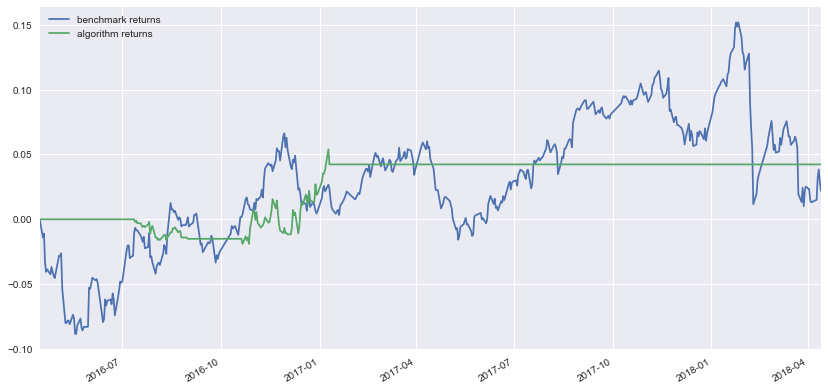

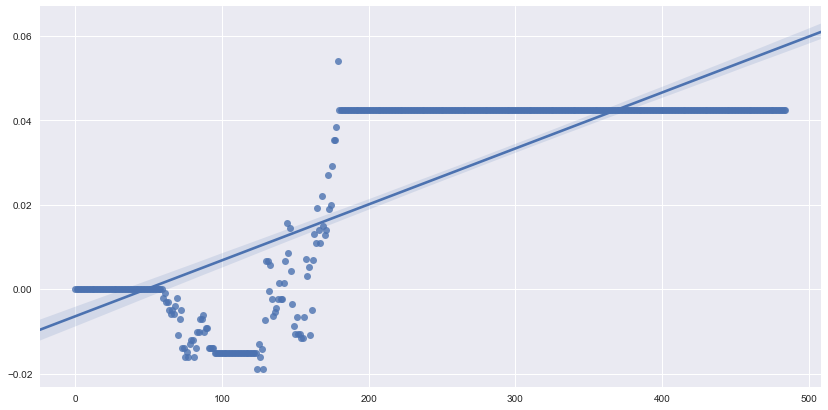

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


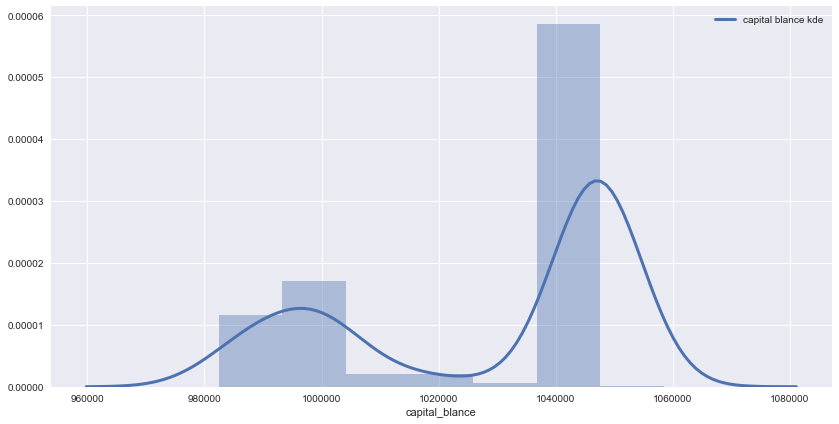

alpha阿尔法:0.0215
beta贝塔:0.0461
Information信息比率:0.0019
策略Sharpe夏普比率: 0.5595
基准Sharpe夏普比率: 0.1538
策略波动率Volatility: 0.0400
基准波动率Volatility: 0.1218


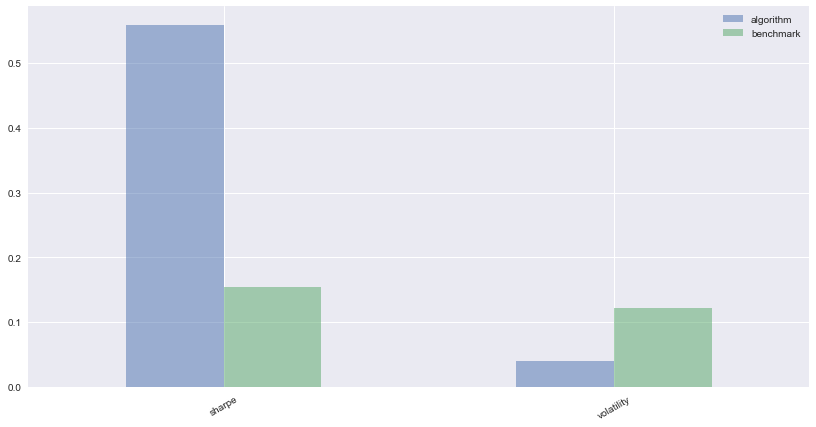

In [24]:
from abupy import AbuMetricsBase # 度量基类

best_score_tuple_grid = score_tuple_array[scorer_returns_max.index[-1]] #scorer_returns_max.index[-1] =12

print(best_score_tuple_grid.buy_factors, best_score_tuple_grid.sell_factors )

AbuMetricsBase.show_general(best_score_tuple_grid.orders_pd,
                            best_score_tuple_grid.action_pd,
                            best_score_tuple_grid.capital,
                            best_score_tuple_grid.benchmark,
                            only_info=False)
